In [1]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns

import os
from pathlib import Path
import sys
import glob
import re

from itertools import compress

import pickle

In [2]:
# Get the directory of the running notebook
project_root = Path(r"D:\Software-Umgebungen\Doktorarbeit\Jupyter_Notebooks\Doktorarbeit_Magnetresonanzspektroskopie\Doktorarbeit-Gehirn-MRS")

sys.path.append(str(project_root))

In [3]:
from Variables.Classes import dataset_categ # Formatierung und Anderes
from Variables.constants import NEXC, EXC, FILE_NAMES, VP_NAMES, VP_POSITIONEN_VOLLSTAENDIG
from Darstellungen.plotting import alter_histogramm
from Postprocessing.data_sanitizing import spec_selec_dataset, entferne_nbekannt
from Farbtonerstellung.hues import color_selec_categ_histogram

# Lade die gepickleten Dataframes

In [4]:
os.chdir(r"D:\Software-Umgebungen\Doktorarbeit\Jupyter_Notebooks\Spektrendarstellung\Pickled_Data")
with open('df_pickled.pickle','rb') as f:
    ds = pickle.load(f)

# Lade die Kategorien von Serial Object

In [5]:
os.chdir(r"D:\Software-Umgebungen\Doktorarbeit\Jupyter_Notebooks\Kategorienbildung\pickled_data")
with open('kategorien.pkl', 'rb') as f:
    kategorienliste = pickle.load(f)

# Erweitere die Dataset-Klasse

In [6]:
ds = dataset_categ(ds,kategorienliste)

# Funktionsdefinitionen

## Voxelpositionen

In [7]:
def vp_count(ds,i,excluded=False):
    df_befund,_,_,_,_ = ds.dataset.load_dataset(i)
    index_selec = spec_selec_dataset(ds,i=i,excluded=excluded)

    vp_counts = df_befund['Voxelposition'].loc[index_selec].value_counts()

    return vp_counts

In [8]:
def vp_barplot(ds,i,ax=None,excluded=False):
    if not ax:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(1,1,1)
    else:
        fig = ax.figure
    
    vp_counts = vp_count(ds,i,excluded=excluded)
    data = pd.Series(np.zeros(len(VP_POSITIONEN_VOLLSTAENDIG)),index=VP_POSITIONEN_VOLLSTAENDIG)

    for vp_pos in VP_POSITIONEN_VOLLSTAENDIG:
        if vp_pos in vp_counts.index:
            data[vp_pos] = vp_counts[vp_pos]
        
    ax = sns.barplot(y=data,ax=ax, hue=data.index, legend=True, gap=0.3)
    ax.text(0.9, 0.75, f'n = {vp_counts.sum()}', transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',horizontalalignment='center')
        
    return fig

## Befundzählung

In [9]:
# Erstelle eine Master-Befundliste aus allen 4 Datensätzen und zähle, dann alle zusammen
def zaehlung_befunde(ds,excluded=False):
    master_list = []
    for i in range(1,5):
        befundliste,_,_,_,_ = ds.dataset.load_dataset(i)
        index_selec = spec_selec_dataset(ds,i=i,excluded=excluded)
        master_list.extend(befundliste['Befund'].loc[index_selec].values)

    master_series = pd.Series(master_list)
    master_dataframe = pd.DataFrame({'Gesamtanzahl': master_series.value_counts()})

    for i, name in enumerate(['Feldstärke 1,5T und Echozeit 135ms','Feldstärke 1,5T und Echozeit 30ms','Feldstärke 3T und Echozeit 135ms','Feldstärke 3T und Echozeit 30ms']):
        # Cave! Zero-Indexing
        befundliste,_,_,_,_ = ds.dataset.load_dataset(i+1)
        index_selec = spec_selec_dataset(ds,i=i+1,excluded=excluded)

        master_dataframe[name] = master_dataframe.apply(lambda row: np.sum(row.name==befundliste['Befund'].loc[index_selec]),axis=1)

    return master_dataframe

## Kategorienzählung

In [10]:
def categ_count(ds,i,excluded=False):
    df_befund,_,_,_,_ = ds.dataset.load_dataset(i)
    index_selec = spec_selec_dataset(ds,i=i,excluded=excluded)
    index_selec = entferne_nbekannt(ds,i,index_selec)

    categ_counts = df_befund['Diagnosekategorie'].loc[index_selec].value_counts()

    return categ_counts

# Namenszusätze und richtiger Pfad

In [11]:
os.chdir(r'D:\Software-Umgebungen\Doktorarbeit\Patienten_Statistik')

# Eigentliche Darstellungen

## Alter

### Ohne ausgeschlossene Spektren

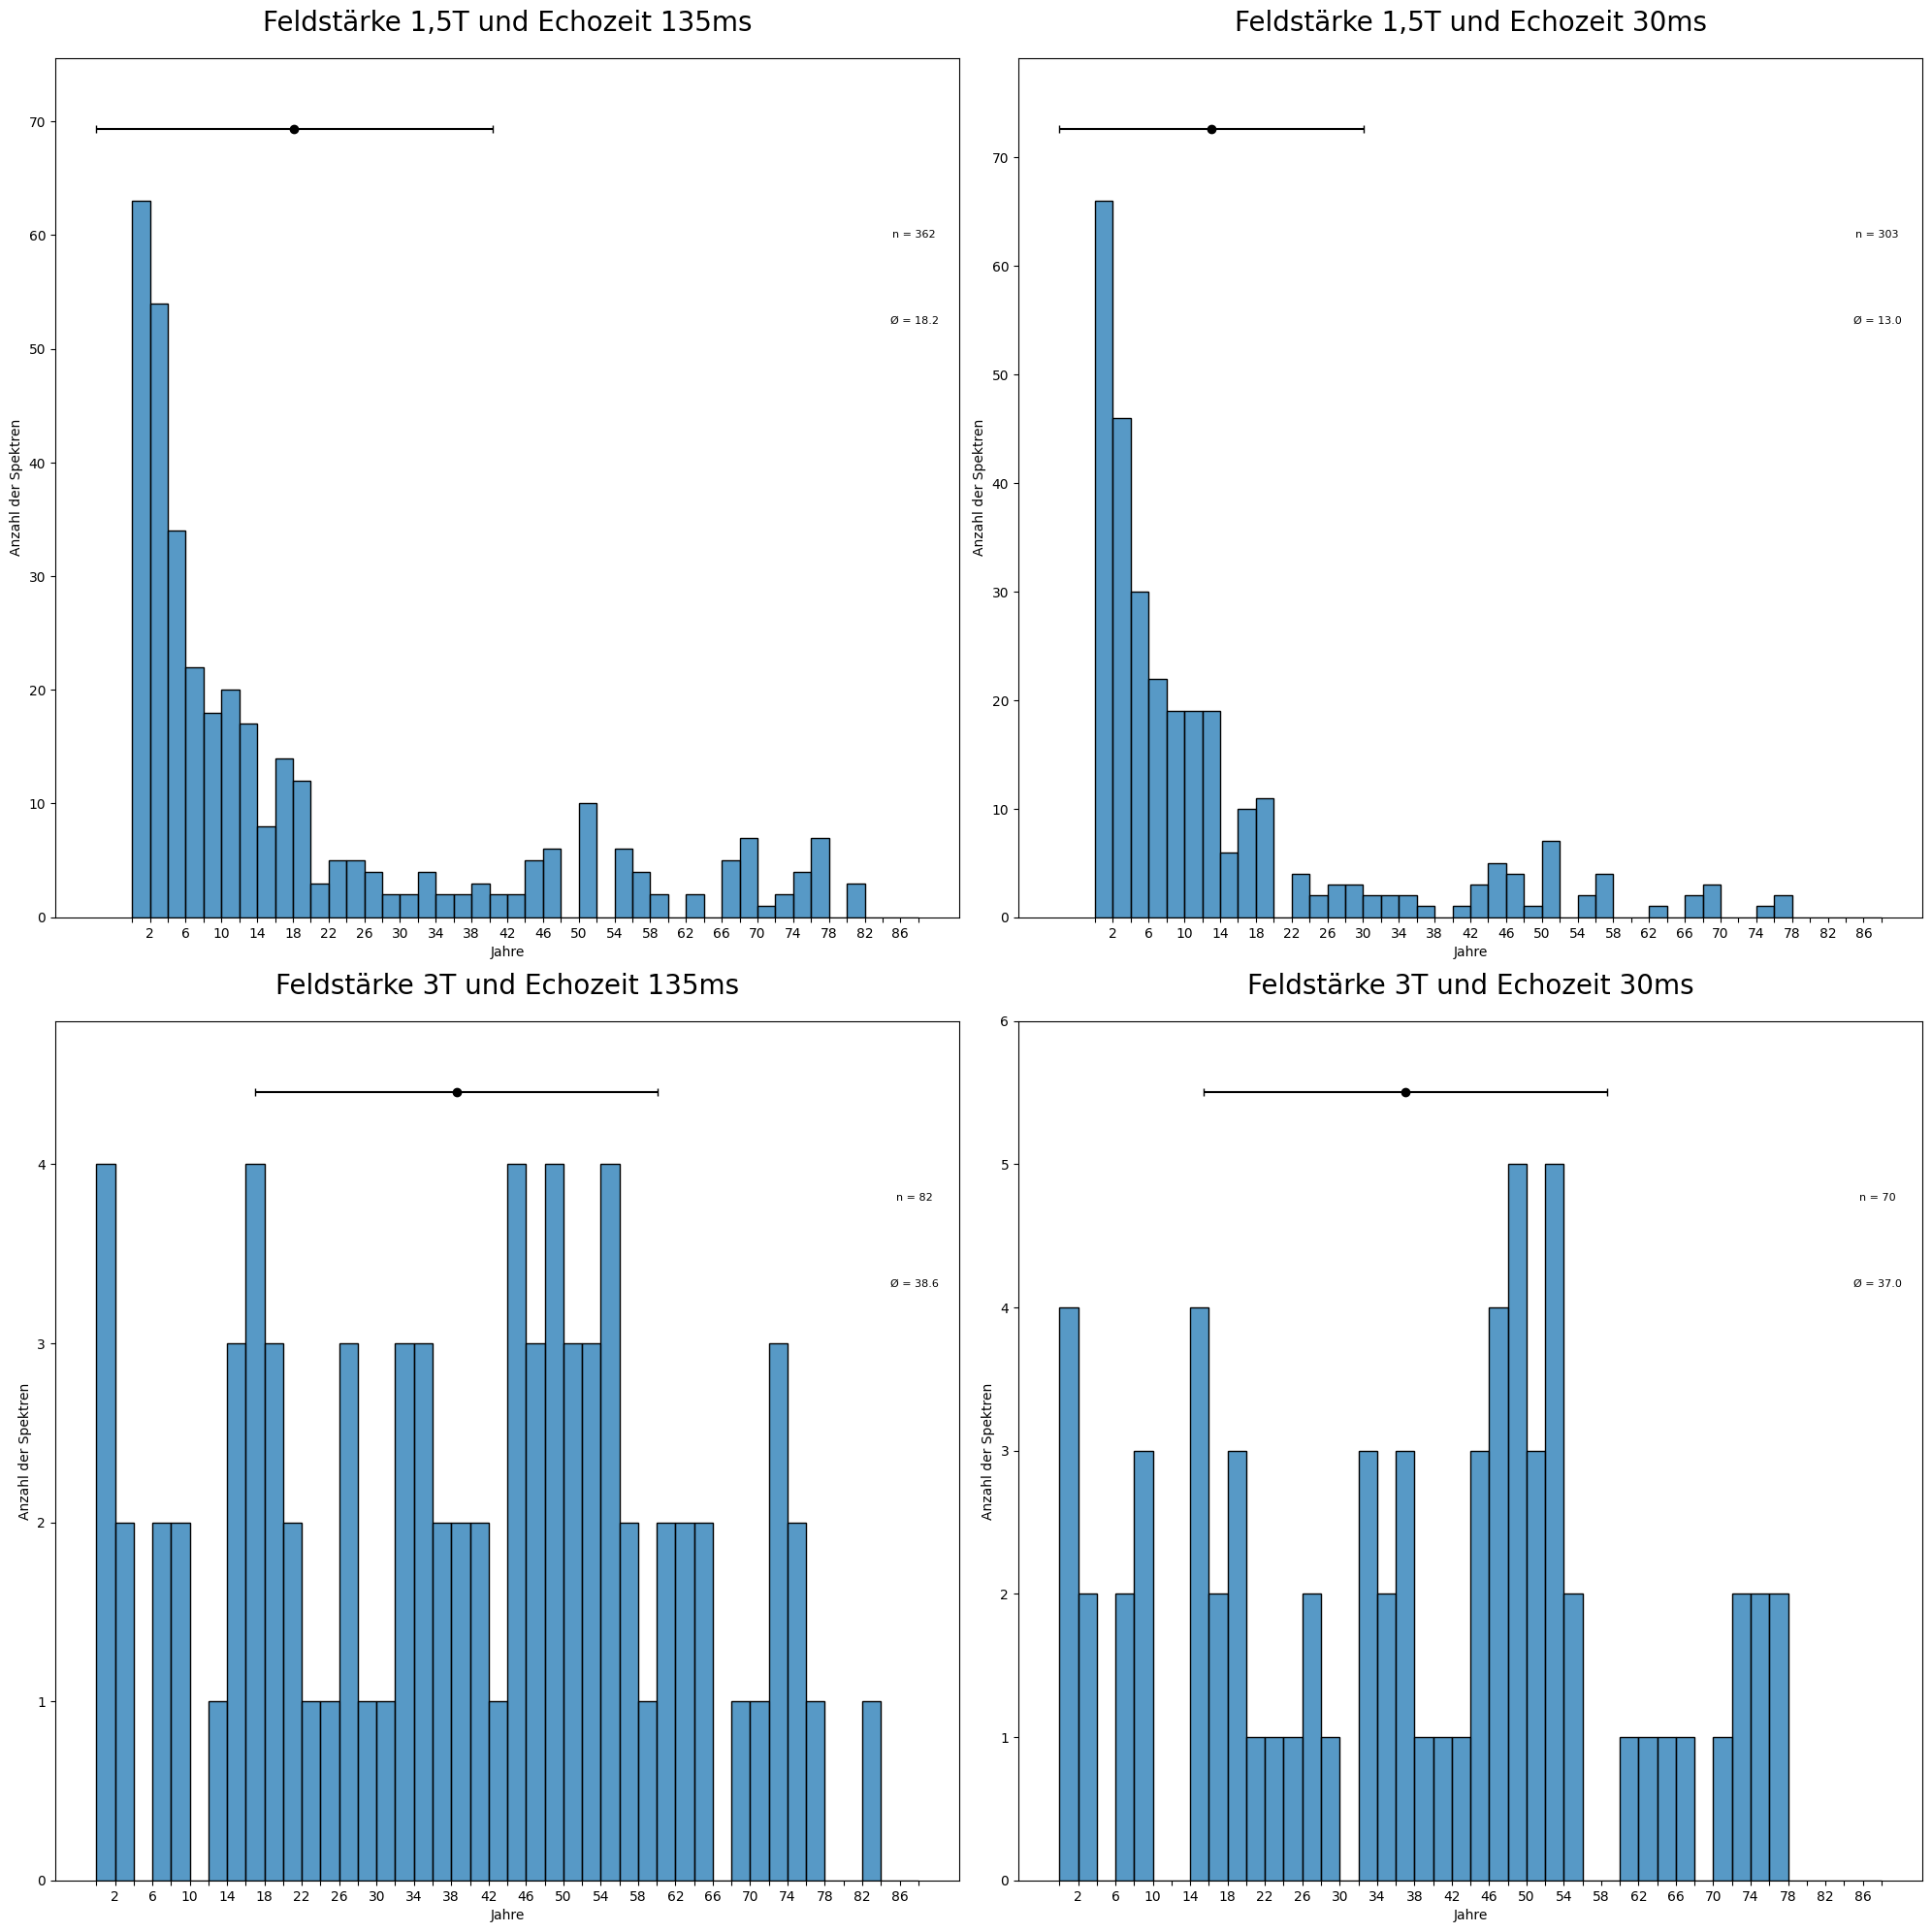

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"
    
    alter_histogramm(ds,i=i+1,ax=ax) #wegen Zero-Indexing
    ax.set_title(label=title, size=20, pad=20)

    plt.tight_layout(pad=1, h_pad=1.0, w_pad=1.0)

In [13]:
fig = ax.figure
# fig.savefig('Altersverteilung'+NEXC)

### Nur ausgeschlossene Spektren

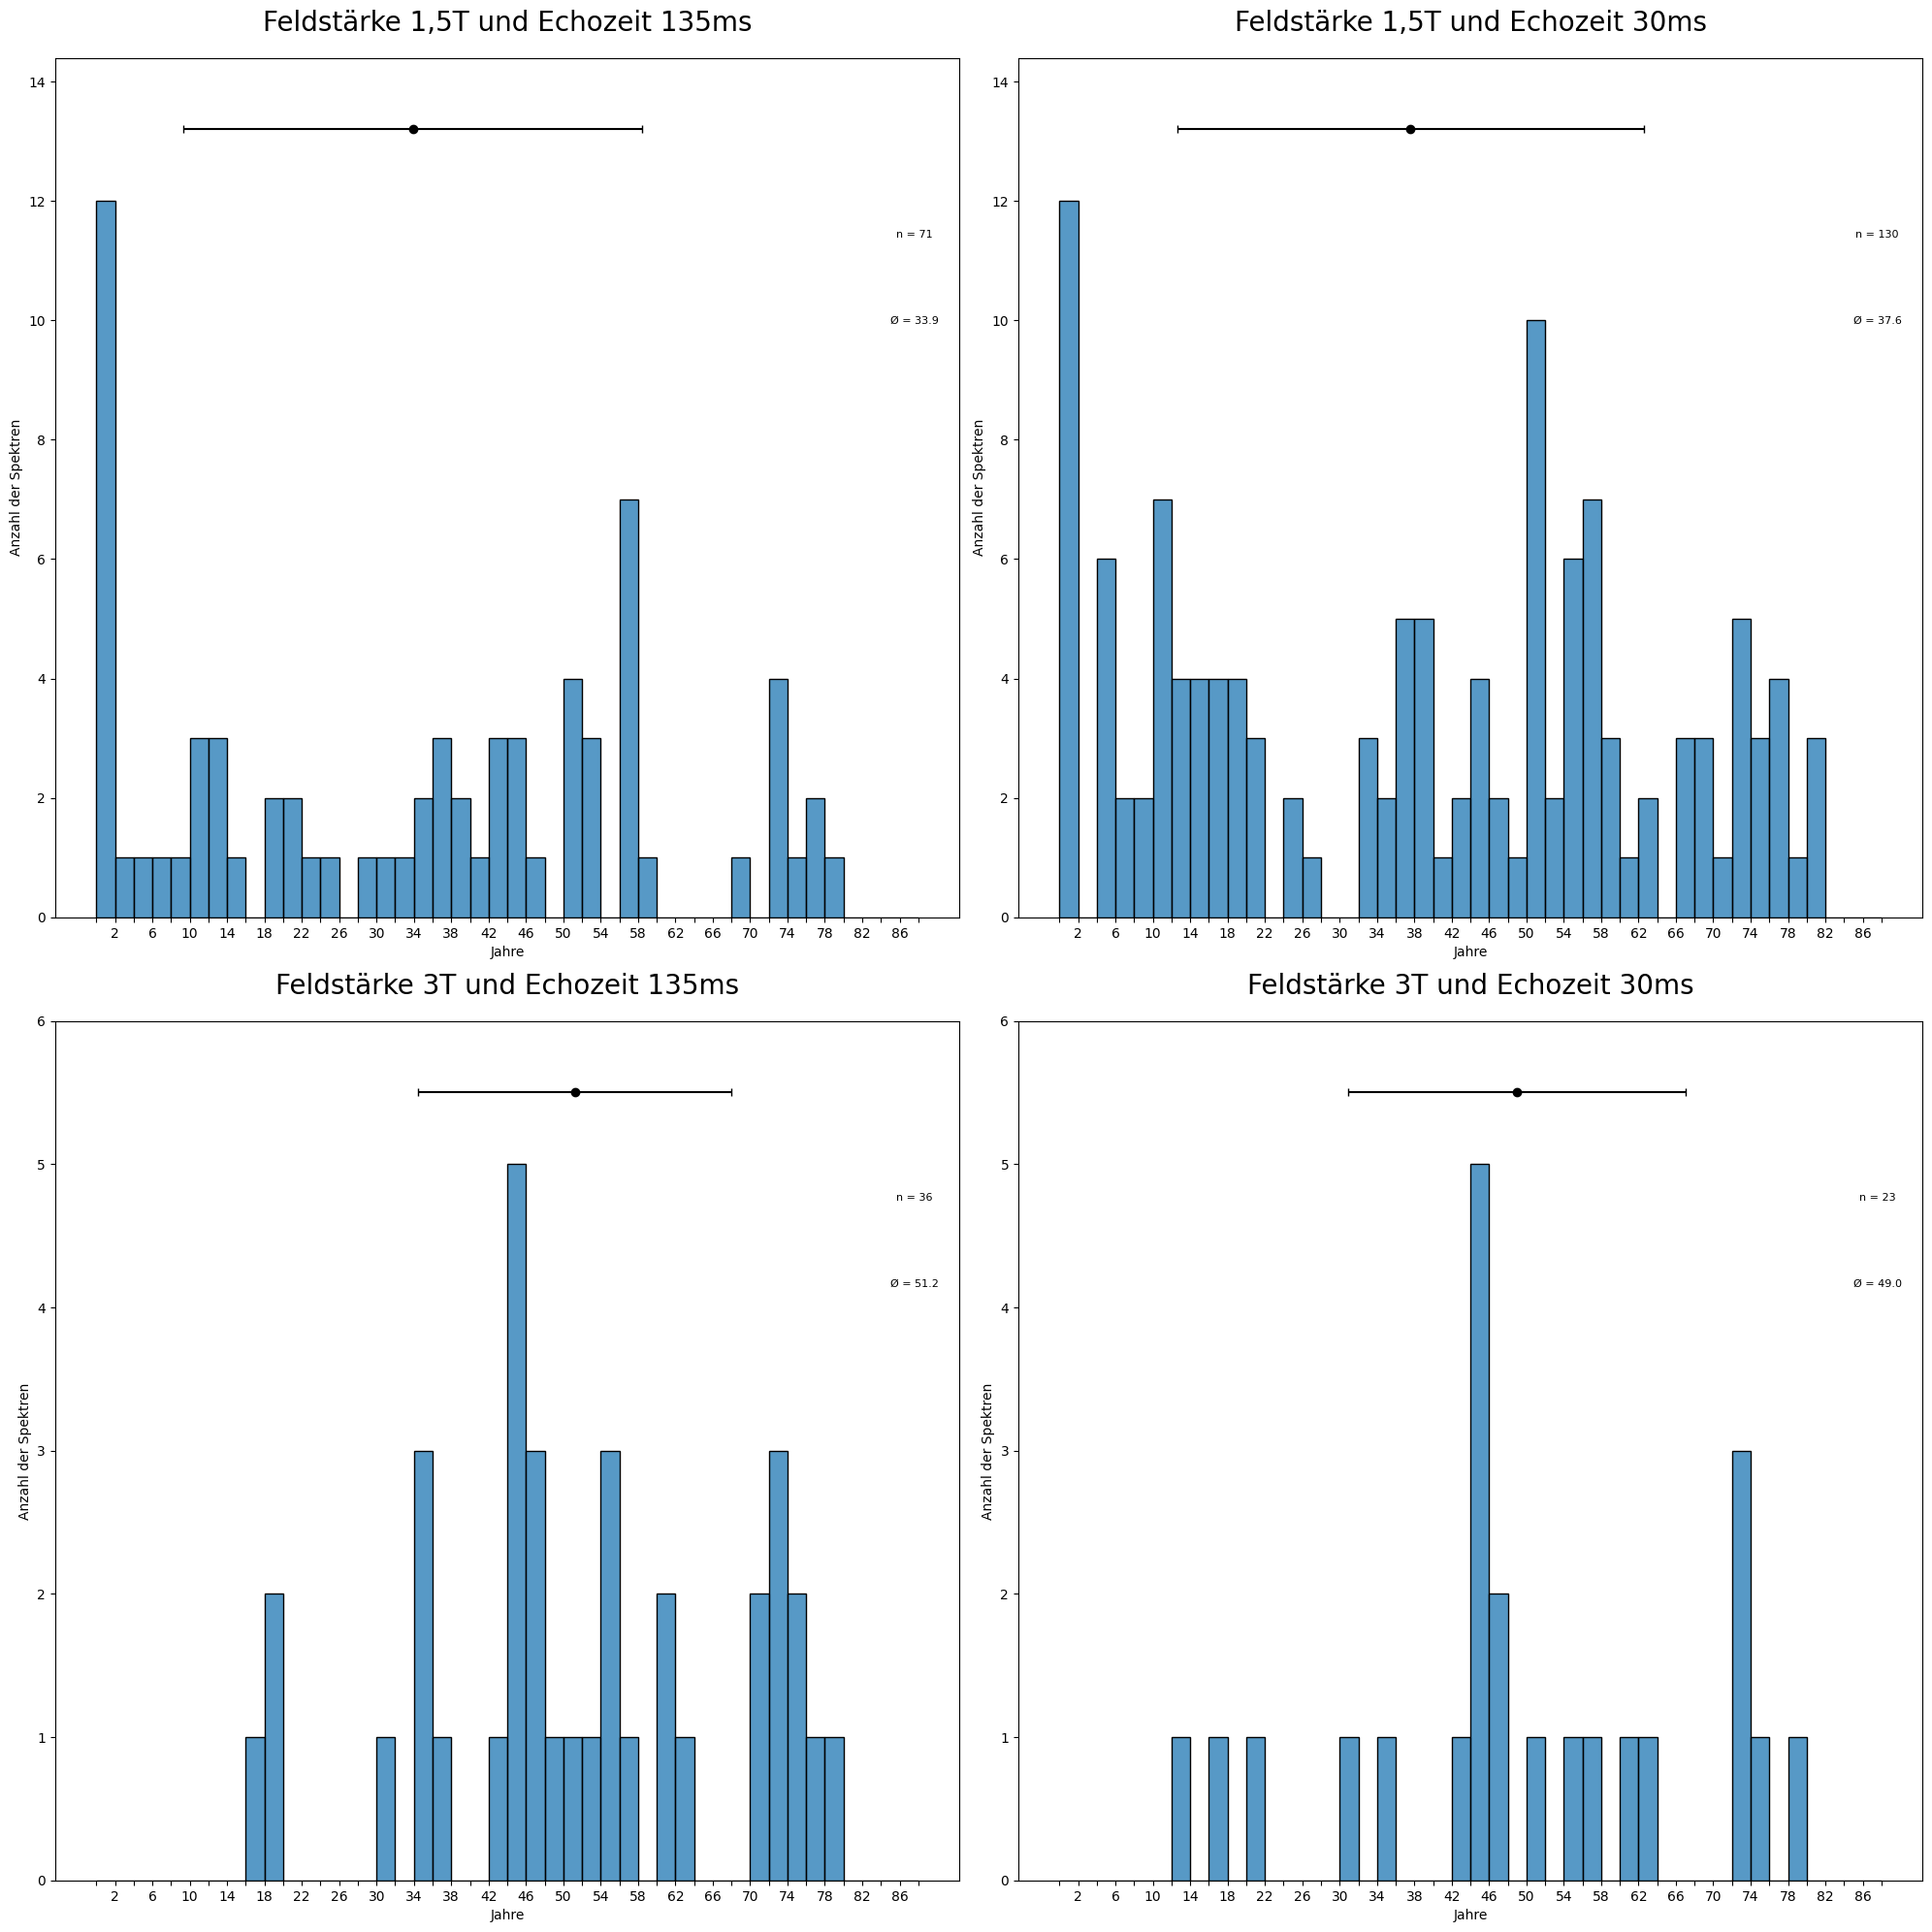

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"
    
    alter_histogramm(ds,i=i+1,ax=ax,excluded=True) #wegen Zero-Indexing
    ax.set_title(label=title, size=20, pad=20)

    plt.tight_layout(pad=1, h_pad=1.0, w_pad=1.0)

In [15]:
fig = ax.figure
# fig.savefig('Altersverteilung'+EXC)

## Voxelpositionen

### Ohne ausgeschlossene Spektren

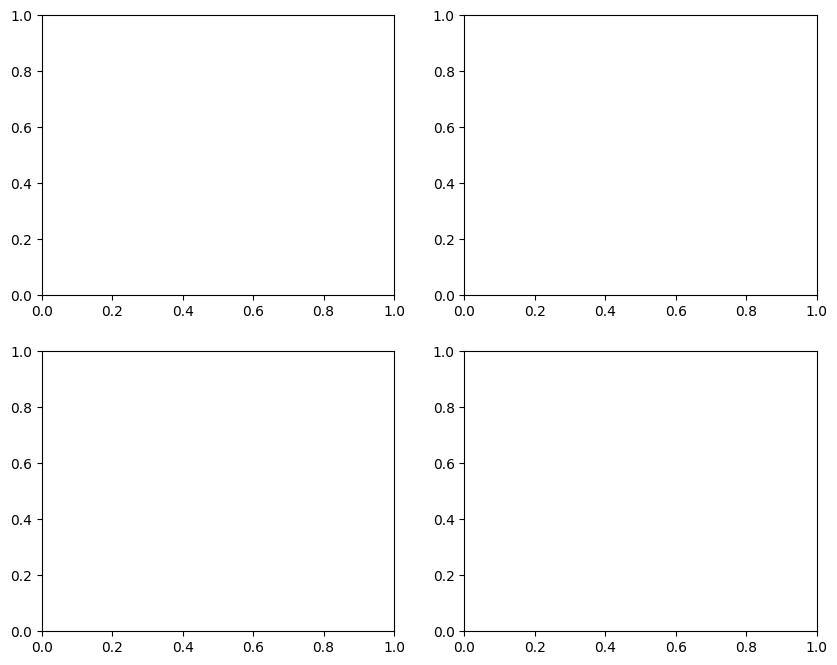

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flat

In [17]:
for i, ax in enumerate(axes):
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"

    vp_barplot(ds,i=i+1,ax=ax) # wegen Zero-Indexing

    ax.set_title(title)
    plt.sca(ax)
    ax.set_ylabel('Zahl der Spektren')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.legend(ncols=2)
    plt.grid(True,linestyle='--',axis='y')

plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)

In [18]:
fig = ax.figure
# fig.savefig('VP_Verteilung'+NEXC)

### Nur ausgeschlossene Spektren

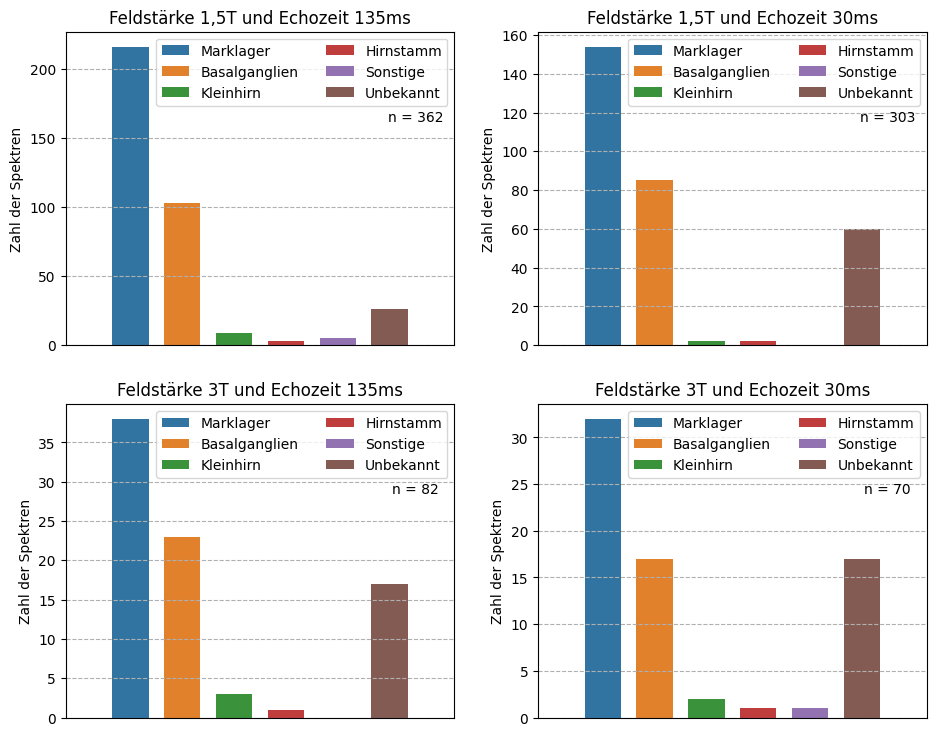

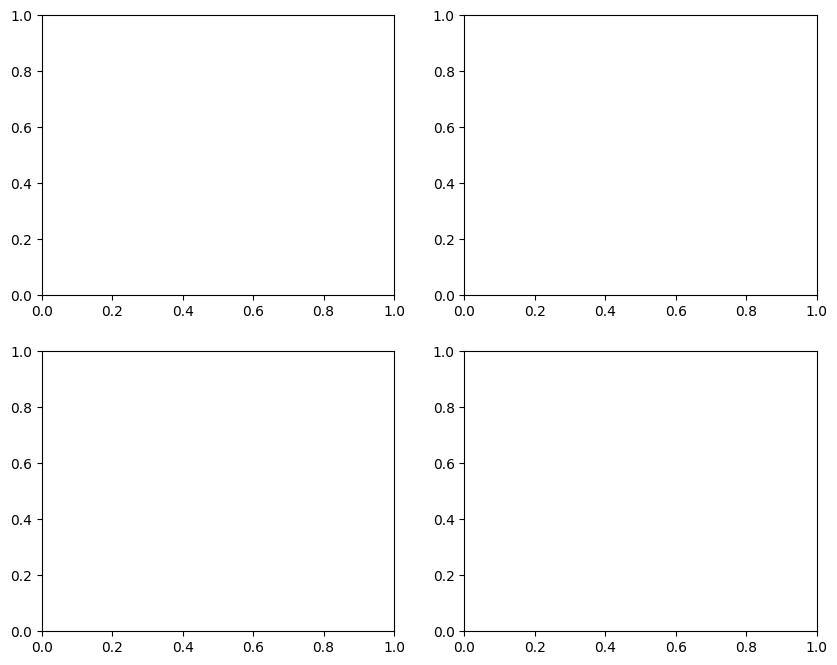

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flat

In [20]:
for i, ax in enumerate(axes):
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"

    vp_barplot(ds,i=i+1,ax=ax,excluded=True) # wegen Zero-Indexing

    ax.set_title(title)
    plt.sca(ax)
    ax.set_ylabel('Zahl der Spektren')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.legend(ncols=2)
    plt.grid(True,linestyle='--',axis='y')

plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)

In [21]:
fig = ax.figure
# fig.savefig('VP_Verteilung'+EXC)

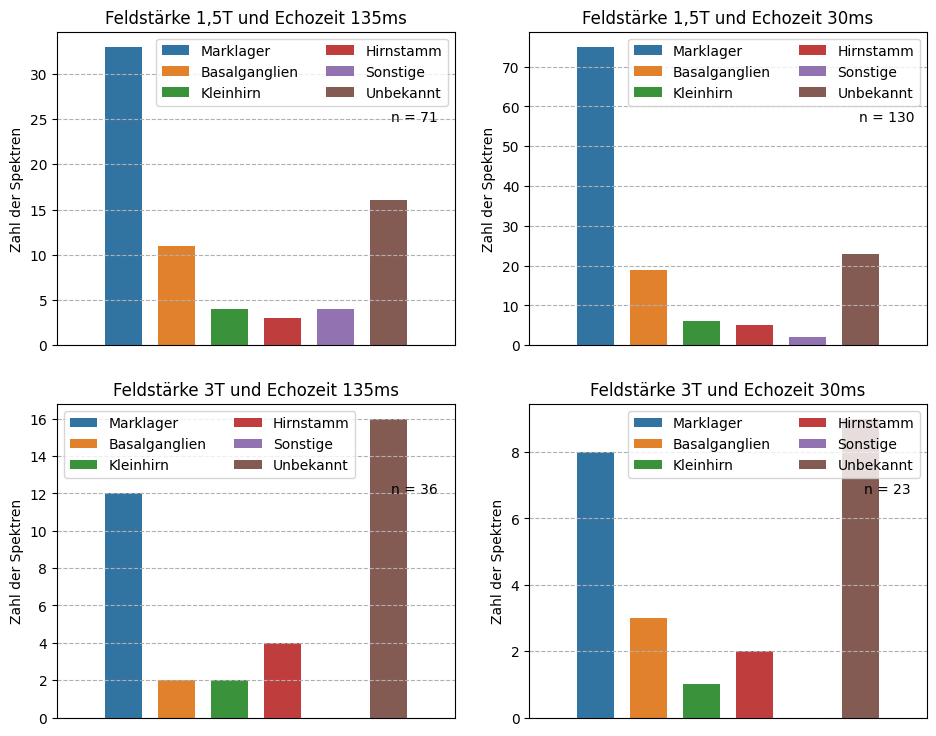

In [22]:
fig

## Befundanzahl

### Pfad wechseln

In [23]:
os.chdir(r"D:\Software-Umgebungen\Doktorarbeit\Befundliste_Zählung")

### Ohne ausgeschlossene Spektren

In [24]:
master_dataframe = zaehlung_befunde(ds, False)

In [25]:
master_dataframe.to_excel("Befundliste_Zaehlung_eingeschlossen.xlsx")

### Nur ausgeschlossene Spektren

In [26]:
master_dataframe = zaehlung_befunde(ds, True)

In [27]:
master_dataframe.to_excel("Befundliste_Zaehlung_ausgeschlossen.xlsx")

## Kategorien

In [28]:
os.chdir(r'D:\Software-Umgebungen\Doktorarbeit\Patienten_Statistik')

### Ohne ausgeschlossene Spektren

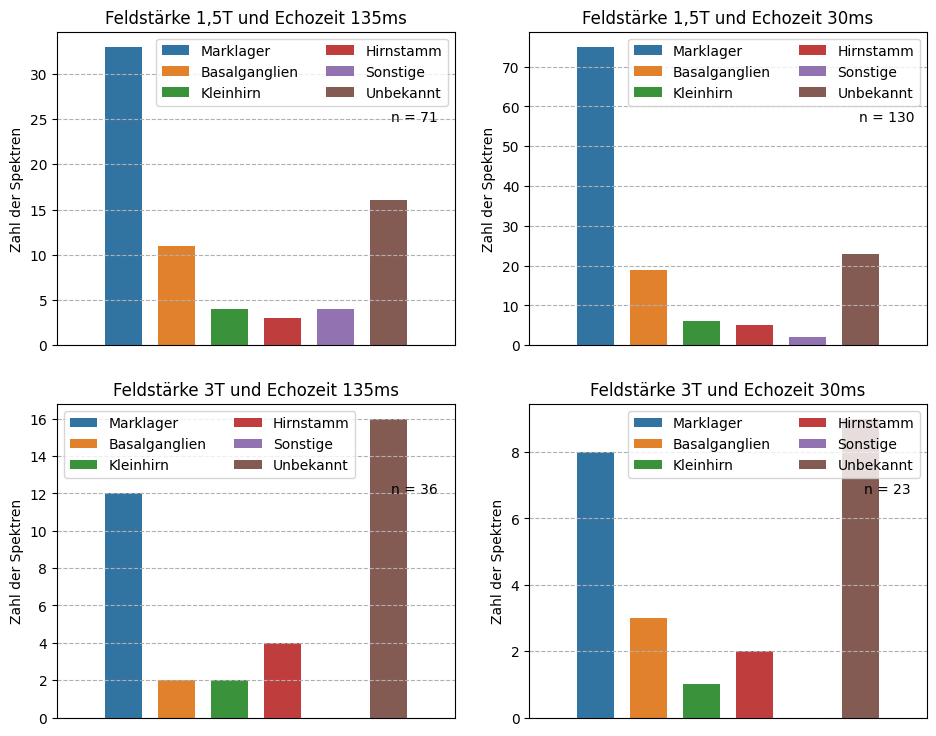

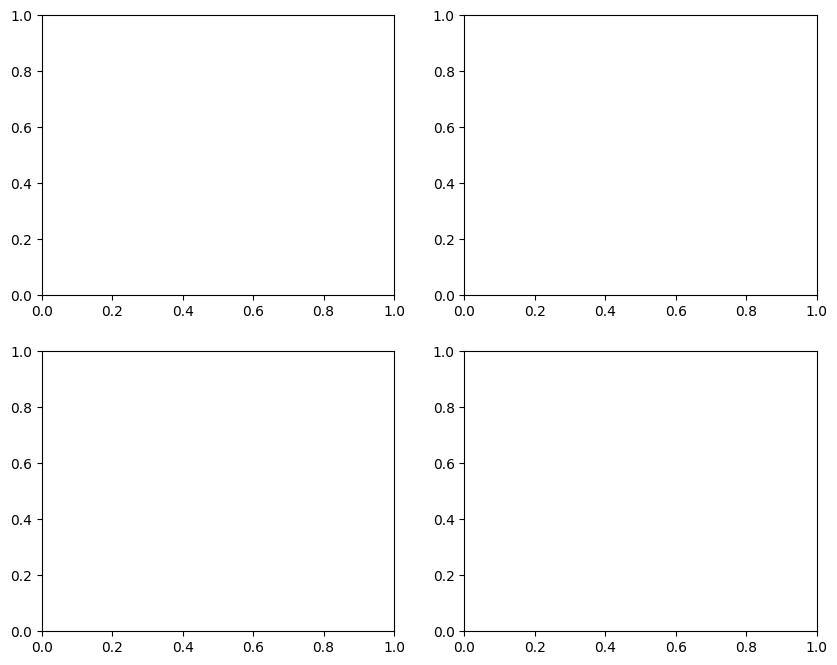

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flat

In [30]:
for i, ax in enumerate(axes):
    # Anzeige des Datensatzes
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"

    categ_counts = categ_count(ds,i+1) # wegen Zero-Indexing
    n = categ_counts.sum()

    ax = categ_counts.plot(kind='bar',color=color_selec_categ_histogram(categ_counts,kategorienliste),ax=ax)
    ax.set_xticks([])
    ax.set_ylabel('Anzahl der Spektren',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # keine Anzeige von Nachkommastellen

    ax.text(0.85, 0.8, f'n = {n}', transform=ax.transAxes, 
                fontsize=8, verticalalignment='top',horizontalalignment='center') # Gesamtzahl der Spektren
    ax.set_title(title)

In [31]:
fig = ax.figure
# fig.savefig('Kategorien_Verteilung'+NEXC)

### Nur ausgeschlossene Spektren

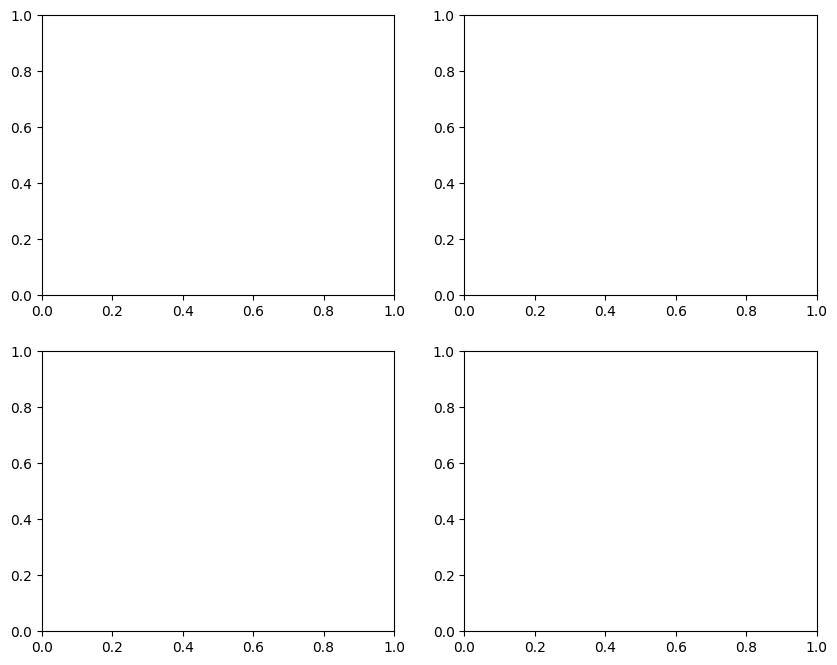

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flat

In [33]:
for i, ax in enumerate(axes):
    # Anzeige des Datensatzes
    title = FILE_NAMES[i].strip('*')
    title = f"Feldstärke {title.split('_')[1]} und Echozeit {title.split('_')[0]}"

    categ_counts = categ_count(ds,i+1,excluded=True) # wegen Zero-Indexing
    n = categ_counts.sum()

    ax = categ_counts.plot(kind='bar',color=color_selec_categ_histogram(categ_counts,kategorienliste),ax=ax)
    ax.set_xticks([])
    ax.set_ylabel('Anzahl der Spektren',fontsize=12)
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('')

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # keine Anzeige von Nachkommastellen

    ax.text(0.85, 0.8, f'n = {n}', transform=ax.transAxes, 
                fontsize=8, verticalalignment='top',horizontalalignment='center') # Gesamtzahl der Spektren
    ax.set_title(title)

In [34]:
fig = ax.figure
# fig.savefig('Kategorien_Verteilung'+EXC)